In [1]:
# Import packages
import pandas as pd, numpy as np
import os, sys, glob, re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table
import statsmodels.api as sm

# Main goal: replicate Figure 1 (only for US)

## Exports

In [2]:
df_exports = pd.read_csv(r'C:\Users\jasonjia\Dropbox\shared_spaces\Jason-Kilian\replication_cities_hetfirms\data\exports_ita.csv')
# Process df_exports
df_exports = df_exports[['MSA Full Name', '2012']].dropna()
df_exports.columns = ['msa_name', 'exports_2012']
# Remove non/other areas
df_exports = df_exports.iloc[:-2,:]
df_exports = df_exports.reset_index(drop=True)
df_exports['msa_name'] = df_exports['msa_name'].str.strip()
df_exports

,msa_name,exports_2012
0,"Abilene, TX",9.291774e+07
1,"Aguadilla-Isabela, PR",6.370887e+08
2,"Akron, OH",3.821459e+09
3,"Albany, GA",2.816581e+08
4,"Albany-Schenectady-Troy, NY",3.420058e+09
...,...,...
365,"Yauco, PR",5.304613e+07
366,"York-Hanover, PA",1.888985e+09
367,"Youngstown-Warren-Boardman, OH-PA",1.211892e+09
368,"Yuba City, CA",3.091096e+08


## Population

In [3]:
def replace_msa_names(df_col):
    df_col = df_col.str.replace('Mayagüez, PR', 'Mayaguez, PR')
    df_col = df_col.str.replace('Nashville-Davidson--Murfreesboro--Franklin, TN', 'Nashville-Davidson-Murfreesboro-Franklin, TN')
    df_col = df_col.str.replace('San Germán, PR', 'San German, PR')
    df_col = df_col.str.replace('San Juan-Bayamón-Caguas, PR', 'San Juan-Bayamon-Caguas, PR')
    df_col = df_col.str.replace('Scranton--Wilkes-Barre, PA', 'Scranton-Wilkes-Barre, PA')
    return df_col

In [4]:
df_pop = pd.read_excel(r'C:\Users\jasonjia\Dropbox\shared_spaces\Jason-Kilian\replication_cities_hetfirms\data\cbsa-met-est2019-annres.xlsx', skiprows=3)
# Process df_pop
df_pop = df_pop.iloc[2:-5,[0,5]]
df_pop.columns = ['msa_name', 'pop_2012']
df_pop = df_pop.dropna()
# Remove all metro divisions
df_pop = df_pop[~df_pop['msa_name'].str.contains('Metro Division')]
# Remove the starting '.' and ending 'Metro Area'
df_pop['msa_name'] = df_pop['msa_name'].str.strip()
df_pop['msa_name'] = df_pop['msa_name'].str.replace('^\.', '', regex=True)
df_pop['msa_name'] = df_pop['msa_name'].str.replace('Metro Area', '')
df_pop['msa_name'] = df_pop['msa_name'].str.strip()
# Replace certain MSA names to match with df_exports later on
df_pop['msa_name'] = replace_msa_names(df_pop['msa_name'])
df_pop = df_pop.reset_index(drop=True)
df_pop

,msa_name,pop_2012
0,"Abilene, TX",167442.0
1,"Akron, OH",702109.0
2,"Albany, GA",153976.0
3,"Albany-Lebanon, OR",118273.0
4,"Albany-Schenectady-Troy, NY",874698.0
...,...,...
389,"Mayaguez, PR",111845.0
390,"Ponce, PR",253345.0
391,"San German, PR",135185.0
392,"San Juan-Bayamon-Caguas, PR",2295419.0


In [5]:
# Merge df_pop (394 rows) with df_exports (370 rows), keeping only entries in both tables
# Note that only 6 rows are lost from df_exports, so this is a good match.
df_pop_exports = df_pop.merge(df_exports, on='msa_name', how='inner')
df_pop_exports

,msa_name,pop_2012,exports_2012
0,"Abilene, TX",167442.0,9.291774e+07
1,"Akron, OH",702109.0,3.821459e+09
2,"Albany, GA",153976.0,2.816581e+08
3,"Albany-Schenectady-Troy, NY",874698.0,3.420058e+09
4,"Albuquerque, NM",901939.0,1.790610e+09
...,...,...,...
358,"Mayaguez, PR",111845.0,1.096283e+07
359,"Ponce, PR",253345.0,5.754300e+08
360,"San German, PR",135185.0,1.093687e+08
361,"San Juan-Bayamon-Caguas, PR",2295419.0,1.759624e+10


## MSA code -> MSA name crosswalk

In [6]:
msa_crosswalk = pd.read_csv(r'C:\Users\jasonjia\Dropbox\shared_spaces\Jason-Kilian\replication_cities_hetfirms\data\msa_crosswalk.csv',skiprows=2)
# Process msa_crosswalk
msa_crosswalk = msa_crosswalk.iloc[:-3,:]
msa_crosswalk = msa_crosswalk[msa_crosswalk['Metropolitan/Micropolitan Statistical Area'] == 'Metropolitan Statistical Area']
msa_crosswalk = msa_crosswalk[['CBSA Code', 'CBSA Title']]
msa_crosswalk.columns = ['msa', 'msa_name']
msa_crosswalk = msa_crosswalk.dropna()
msa_crosswalk['msa'] = msa_crosswalk['msa'].astype('int64')
msa_crosswalk['msa_name'] = msa_crosswalk['msa_name'].str.strip()
print('msa_crosswalk.shape:', msa_crosswalk.shape)
# Remove duplicated MSAs (note that there is a 1:1 match from msa to msa_name)
msa_crosswalk = msa_crosswalk.drop_duplicates(['msa', 'msa_name'])
print('msa_crosswalk.shape:', msa_crosswalk.shape)
msa_crosswalk = msa_crosswalk.drop_duplicates('msa_name')
print('msa_crosswalk.shape:', msa_crosswalk.shape)
msa_crosswalk

msa_crosswalk.shape: (1236, 2)
msa_crosswalk.shape: (388, 2)
msa_crosswalk.shape: (388, 2)


,msa,msa_name
3,10180,"Abilene, TX"
9,10380,"Aguadilla-Isabela, PR"
18,10420,"Akron, OH"
21,10500,"Albany, GA"
26,10540,"Albany, OR"
...,...,...
1871,49420,"Yakima, WA"
1873,49620,"York-Hanover, PA"
1874,49660,"Youngstown-Warren-Boardman, OH-PA"
1877,49700,"Yuba City, CA"


## Sales

In [7]:
def get_df_sales(inputfilepath, naics):
    # Process df_sales (Note: The dataset is only for 2012. RCPTOT = Value of sales, shipments, receipts, revenue, or business done ($1,000))
    # EC1200A1.dat (all sectors), EC1231A1 (manufacturing, 31-33)
    df_sales = pd.read_csv(inputfilepath, sep='|', usecols=['MSA', 'RCPTOT', 'NAICS2012', 'NAICS2012_TTL'])
    # Note that this dataset contains the value of sales for NAICS2, NAICS3, NAICS4, NAICS5 and NAICS6. 
    # We only want to keep the sales for NAICS2 to avoid double-counting.
    # Note that some NAICS2 occupy multiple 2-digit codes, so their code looks like '31-33' instead.
    
    # If we are adding up across all NAICS2s: 
    # We add up all sectors excluding '00' ('Total for all sectors'), rather than use '00' directly.
    # This is because '00' does not appear for most MSAs.
    if naics == 'All':
        df_sales = df_sales[(df_sales['NAICS2012'].str.len() == 2) | (df_sales['NAICS2012'].str.contains('-'))]
        df_sales = df_sales[df_sales['NAICS2012'] != '00']
    
    # If we are only using manufacturing NAICS (31-33):
    # Keep only naics = '31-33'.
    elif naics == '31-33':
        df_sales = df_sales[df_sales['NAICS2012'].isin(['31-33'])]
    
    # Print the NAICS codes remaining
    print("Unique NAICS2:", [','.join(df_sales['NAICS2012'].unique())])

    # Each MSA has multiple rows, one for each NAICS2. We aggregate by taking the sum across all NAICS.
    df_sales = df_sales.groupby('MSA').sum('RCPTOT').reset_index()
    df_sales.columns = ['msa', 'sales_2012']
    df_sales['sales_2012'] = df_sales['sales_2012'] * 1000 # because the column is in 1000s.
    df_sales = df_sales[df_sales['sales_2012'] > 0]
    print("Number of unique MSAs:", df_sales['msa'].nunique())
    
    return df_sales

## Merge, filter and process df

In [8]:
def merge_df_sales_with_pop_and_exports(df_sales, msa_crosswalk, df_pop_exports):
    # Merge df_sales with MSA crosswalk. Note that note all MSAs in df_sales are valid, and we only keep the inner merge.
    # We see that no rows from MSAa crosswalk are lost, which is good.
    print('df_sales.shape (before merge):', df_sales.shape)
    df_sales = df_sales.merge(msa_crosswalk, on='msa', how='inner')
    print('df_sales.shape (df_sales + msa_crosswalk):', df_sales.shape)
    # Merge df_pop_exports with df_sales.
    df = df_pop_exports.merge(df_sales, on='msa_name', how='inner')
    print('df.shape (df_sales + msa_crosswalk + df_pop_exports):', df.shape)
    return df

In [9]:
def filter_and_process_df(df):
    # Filter for pop > 100000 and exports > 0
    print("df.shape:", df.shape) 
    df = df[df['pop_2012'] > 100000]
    print("df.shape (after filtering for pop > 100000):", df.shape)
    df = df[df['exports_2012'] > 0] # no effect
    print("df.shape (after filtering for exports > 0):", df.shape)
    # Get export intensity = exports / sales
    df['export_intensity_2012'] = df['exports_2012'] / df['sales_2012']
    return df

In [10]:
sales_inputfilepath = Path(r'C:\Users\jasonjia\Dropbox\shared_spaces\Jason-Kilian\replication_cities_hetfirms\data\EC1200A1.dat')

In [11]:
df_sales = get_df_sales(sales_inputfilepath, naics='All')
df = merge_df_sales_with_pop_and_exports(df_sales, msa_crosswalk, df_pop_exports)
df = filter_and_process_df(df)
df

Unique NAICS2: ['21,22,23,31-33,42,44-45,48-49,51,52,53,54,55,56,61,62,71,72,81']
Number of unique MSAs: 930
df_sales.shape (before merge): (930, 2)
df_sales.shape (df_sales + msa_crosswalk): (388, 3)
df.shape (df_sales + msa_crosswalk + df_pop_exports): (321, 5)
df.shape: (321, 5)
df.shape (after filtering for pop > 100000): (299, 5)
df.shape (after filtering for exports > 0): (299, 5)


,msa_name,pop_2012,exports_2012,msa,sales_2012,export_intensity_2012
0,"Abilene, TX",167442.0,9.291774e+07,10180,31351915000,0.002964
1,"Akron, OH",702109.0,3.821459e+09,10420,172481910000,0.022156
2,"Albany, GA",153976.0,2.816581e+08,10500,26157249000,0.010768
3,"Albany-Schenectady-Troy, NY",874698.0,3.420058e+09,10580,180600236000,0.018937
4,"Albuquerque, NM",901939.0,1.790610e+09,10740,148919019000,0.012024
...,...,...,...,...,...,...
315,"Youngstown-Warren-Boardman, OH-PA",558530.0,1.211892e+09,49660,114528501000,0.010582
316,"Yuba City, CA",166963.0,3.091096e+08,49700,14537591000,0.021263
317,"Yuma, AZ",202475.0,3.736332e+08,49740,21084632000,0.017721
318,"Aguadilla-Isabela, PR",330752.0,6.370887e+08,10380,3147787000,0.202393


In [12]:
df_sales_mfg = get_df_sales(sales_inputfilepath, naics='31-33')
df_mfg = merge_df_sales_with_pop_and_exports(df_sales_mfg, msa_crosswalk, df_pop_exports)
df_mfg = filter_and_process_df(df_mfg)
df_mfg

Unique NAICS2: ['31-33']
Number of unique MSAs: 868
df_sales.shape (before merge): (868, 2)
df_sales.shape (df_sales + msa_crosswalk): (385, 3)
df.shape (df_sales + msa_crosswalk + df_pop_exports): (319, 5)
df.shape: (319, 5)
df.shape (after filtering for pop > 100000): (298, 5)
df.shape (after filtering for exports > 0): (298, 5)


,msa_name,pop_2012,exports_2012,msa,sales_2012,export_intensity_2012
0,"Abilene, TX",167442.0,9.291774e+07,10180,3703065000,0.025092
1,"Akron, OH",702109.0,3.821459e+09,10420,36108577000,0.105832
2,"Albany, GA",153976.0,2.816581e+08,10500,6677750000,0.042179
3,"Albany-Schenectady-Troy, NY",874698.0,3.420058e+09,10580,19485869000,0.175515
4,"Albuquerque, NM",901939.0,1.790610e+09,10740,18132185000,0.098753
...,...,...,...,...,...,...
313,"Youngstown-Warren-Boardman, OH-PA",558530.0,1.211892e+09,49660,37727670000,0.032122
314,"Yuba City, CA",166963.0,3.091096e+08,49700,1793283000,0.172371
315,"Yuma, AZ",202475.0,3.736332e+08,49740,2554187000,0.146283
316,"Aguadilla-Isabela, PR",330752.0,6.370887e+08,10380,3147787000,0.202393


## Table 1: City Size and Export Intensity

In [13]:
def get_table1(df):
    # City size
    city_size_obtained = np.round((df['pop_2012'] / 1000).describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]),1)
    city_size_reported = pd.Series([312, 798.8, 'NA', 'NA', 157.5, 277.5, 636.6, 1929.2, 3176.1, 'NA'])
    city_size_reported.index = city_size_obtained.index
    
    # Export intensity
    export_intensity_obtained = np.round(df['export_intensity_2012'].describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]),4)
    export_intensity_reported = pd.Series(['312', '0.1131', 'NA', 'NA', '0.0445', '0.0853', '0.1370', '0.2250', '0.3292', 'NA'])
    export_intensity_reported.index = export_intensity_obtained.index
    
    table1 = pd.concat([city_size_obtained, city_size_reported, export_intensity_obtained, export_intensity_reported], axis=1)
    table1.columns = ['pop_2012_obtained', 'pop_2012_reported', 'export_intensity_2012_obtained', 'export_intensity_2012_reported']
    table1 = table1.drop(index=['std','min','max'])

    # Plot table
    fig, ax = plt.subplots()
    ax.set_axis_off()
    table(ax, table1, loc='center')
    plt.close(fig)
    
    return table1

In [14]:
get_table1(df)

,pop_2012_obtained,pop_2012_reported,export_intensity_2012_obtained,export_intensity_2012_reported
count,299.0,312,299.0000,312
mean,732.4,798.8,0.0186,0.1131
25%,153.3,157.5,0.0072,0.0445
50%,261.9,277.5,0.0119,0.0853
75%,595.3,636.6,0.0206,0.1370
90%,1423.2,1929.2,0.0317,0.2250
95%,2660.7,3176.1,0.0501,0.3292


In [15]:
get_table1(df_mfg)

,pop_2012_obtained,pop_2012_reported,export_intensity_2012_obtained,export_intensity_2012_reported
count,298.0,312,298.0000,312
mean,734.0,798.8,0.1476,0.1131
25%,153.3,157.5,0.0350,0.0445
50%,262.3,277.5,0.0651,0.0853
75%,595.4,636.6,0.1135,0.1370
90%,1446.0,1929.2,0.2021,0.2250
95%,2665.9,3176.1,0.3214,0.3292


## Table 2: Regression of export intensity against city size

In [16]:
model = sm.OLS(np.log(df_mfg['export_intensity_2012']), sm.add_constant(np.log(df_mfg['pop_2012'])))
results = model.fit()
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     export_intensity_2012   R-squared:                       0.062
Model:                               OLS   Adj. R-squared:                  0.059
Method:                    Least Squares   F-statistic:                     19.67
Date:                   Thu, 02 Mar 2023   Prob (F-statistic):           1.30e-05
Time:                           12:02:18   Log-Likelihood:                -400.10
No. Observations:                    298   AIC:                             804.2
Df Residuals:                        296   BIC:                             811.6
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6807 

Text(0.5, 1.0, 'Checking regression results from Statsmodels)')

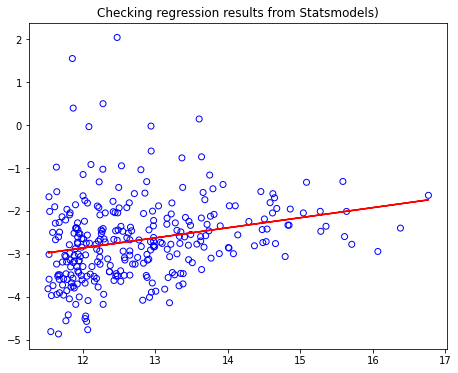

In [17]:
pred_ols = results.get_prediction()
fig, ax = plt.subplots(figsize=(7.5,6))
ax.scatter(np.log(df_mfg['pop_2012']), np.log(df_mfg['export_intensity_2012']), color='blue', facecolor='None')
ax.plot(np.log(df_mfg['pop_2012']), results.fittedvalues, color='red')
ax.set_title('Checking regression results from Statsmodels)')

## Figure 1: Plot (city size, export intensity)

Text(0.5, 1.0, 'United States (sales only from manufacturing industry)')

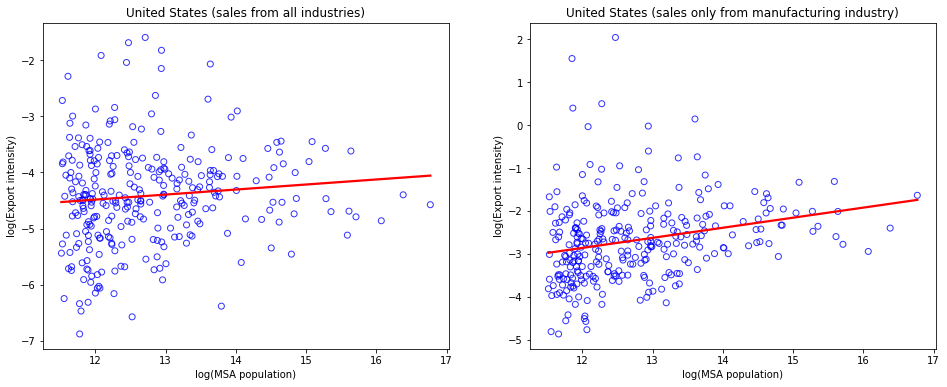

In [18]:
fig, axs = plt.subplots(1,2, figsize=(16,6))

# Plot all industries
sns.regplot(x=np.log(df['pop_2012']), y=np.log(df['export_intensity_2012']), ci=None, scatter_kws={'color':'blue', 'facecolor':'None'}, line_kws={'color':'red'}, ax=axs[0])
axs[0].set_xlabel('log(MSA population)')
axs[0].set_ylabel('log(Export intensity)')
axs[0].set_title('United States (sales from all industries)')

# Plot manufactuing industry
sns.regplot(x=np.log(df_mfg['pop_2012']), y=np.log(df_mfg['export_intensity_2012']), ci=None, scatter_kws={'color':'blue', 'facecolor':'None'}, line_kws={'color':'red'}, ax=axs[1])
axs[1].set_xlabel('log(MSA population)')
axs[1].set_ylabel('log(Export intensity)')
axs[1].set_title('United States (sales only from manufacturing industry)')